In [ ]:
!pwd

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data

In [ ]:
!cd data && unzip PennFudanPed.zip

In [7]:
ls data/PennFudanPed/

Annotation/  PNGImages/  PedMasks/  added-object-list.txt  readme.txt


In [8]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [10]:
image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

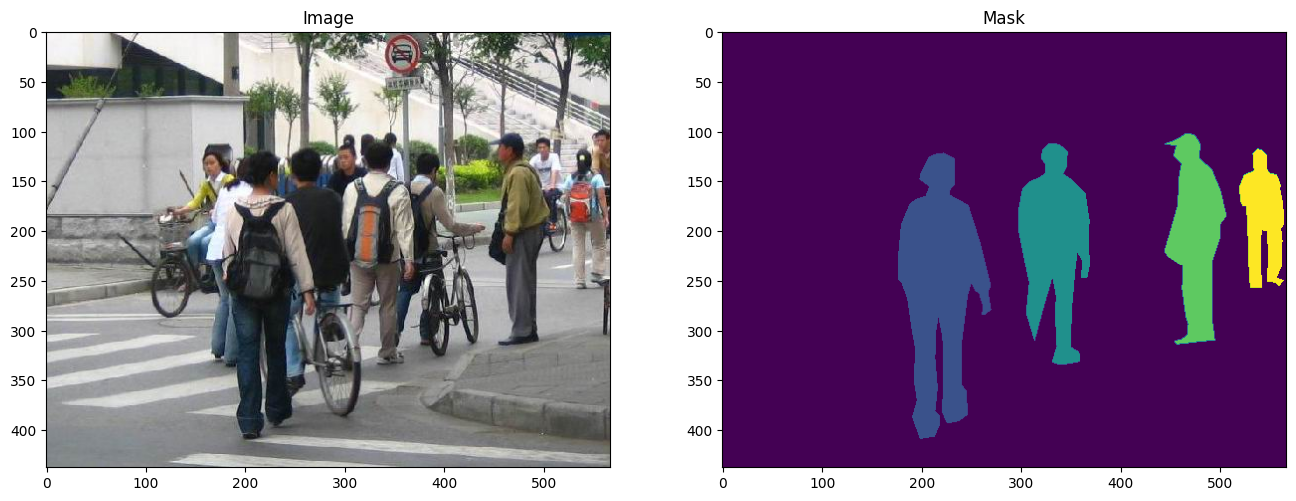

In [11]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [12]:
import os
import torch

In [13]:
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

In [63]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx]) # Last argument represents file-name
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx]) # Last argument represents file-name
        img = read_image(img_path)
        mask = read_image(mask_path)
        obj_ids = torch.unique(mask) # mask 텐서 내 객체에 대한 unique id 리스트 반환
        obj_ids = obj_ids[1:] # 첫 번째 인덱스는 배경을 의미하므로 제외
        num_objs = len(obj_ids)

        # 각 마스크의 자료형을 uint8로 변환
        # 우측에 2개의 차원 추가
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # 각 마스크에 대한 b. box 가져오기
        boxes = masks_to_boxes(masks)

        # 1차원 텐서로, 객체의 수만큼의 크기로, torch.int64 자료형으로, 라벨 생성
        # 실제로는 클래스의 수에 따라 원핫 인코딩 되어야 함
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        # Height(Y_2 - Y_1) x Width(X_2 - X_1)
        # 영역 크기 구하기
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # 현재 이미지에 대한 객체의 수만큼의 크기 및 1차원으로 정수 '0' 텐서 생성
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # 실제 이미지의 경우, tv_tensor.Image 텐서로 래핑
        img = tv_tensors.Image(img)

        target = {} # 딕셔너리로 위에서 얻은 데이터들을 모두 묶음
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None: # transforms가 전달된 것이 있다면
            img, target = self.transforms(img, target) # 현재 이미지와 타겟에 transforms 적용

        return img, target

    def __len__(self):
        return len(self.imgs) # 현재 데이터셋의 크기 반환

# 1 - Finetuning from a pretrained model

In [36]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [37]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [38]:
num_classes = 2 # 1: person, 0: background
in_features = model.roi_heads.box_predictor.cls_score.in_features # 현재 분류기의 입력 피처맵의 수를 획득

In [40]:
# 사전 훈련된 모델의 헤드를 새로운 것으로 변경함
# in_features로 입력을 받고, num_classes의 수에 대한 cls_score를 반환하도록 변경
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 2 - Modifying the model to add a different backbone

In [41]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator # .rpn = Region Proposal Network

In [42]:
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features # 특징 추출 부분만을 가져와 백본으로 사용하겠다

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /home/hwkang/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100.0%


In [44]:
backbone.out_channels = 1280

In [48]:
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
) # 5 x 3 개의 anchor 생성

In [50]:
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

In [51]:
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_poo=roi_pooler
)

# Object detection and instance segmentation model for PennFudan Dataset

In [52]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [77]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [ ]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [55]:
from torchvision.transforms import v2 as T

In [56]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [57]:
import utils

In [64]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

In [65]:
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)
print(output)

{'loss_classifier': tensor(0.1081, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0415, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0309, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0052, grad_fn=<DivBackward0>)}


In [66]:
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [67]:
from engine import train_one_epoch, evaluate

In [68]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [69]:
num_classes = 2

In [70]:
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

In [72]:
indices = torch.randperm(len(dataset)).tolist()
print(indices)

[109, 18, 121, 154, 106, 161, 119, 125, 118, 168, 110, 79, 127, 67, 48, 9, 65, 99, 34, 11, 145, 165, 29, 164, 146, 21, 47, 0, 97, 122, 52, 50, 128, 60, 94, 140, 35, 132, 23, 89, 101, 148, 124, 108, 149, 155, 85, 32, 103, 62, 156, 71, 86, 28, 41, 105, 61, 88, 30, 135, 24, 64, 95, 167, 76, 66, 141, 153, 2, 147, 4, 126, 138, 57, 27, 98, 40, 131, 43, 78, 56, 63, 72, 80, 5, 112, 144, 134, 8, 100, 13, 163, 159, 70, 69, 169, 51, 87, 92, 137, 73, 16, 139, 49, 39, 33, 115, 142, 136, 82, 75, 7, 133, 15, 102, 36, 44, 114, 151, 53, 31, 37, 17, 6, 20, 111, 42, 68, 129, 14, 3, 1, 90, 55, 158, 160, 123, 59, 104, 91, 46, 152, 130, 113, 26, 77, 107, 54, 12, 10, 166, 116, 74, 162, 45, 58, 83, 117, 22, 84, 96, 81, 93, 19, 25, 120, 157, 143, 38, 150]


In [73]:
print(len(dataset))
print(len(dataset_test))

dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

print(len(dataset))
print(len(dataset_test))

170
170
120
50


In [75]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
    collate_fn=utils.collate_fn
)

In [78]:
model = get_model_instance_segmentation(num_classes)

model = model.to(device)

In [80]:
# 모델의 모든 파라미터에 대해 파라미터 p가 학습 가능한 경우에만 리스트에 저장 ⇒ 학습 가능 파라미터 필터링
# 일부 레이어를 고정하고 나머지 레이어만 학습하고자 할 때 사용함
params = [p for p in model.parameters() if p.requires_grad] 
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

In [81]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [82]:
num_epochs = 2

In [83]:
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

print("DONE")

/home/hwkang/jupyter/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: [0]  [ 0/60]  eta: 0:00:58  lr: 0.000090  loss: 3.6763 (3.6763)  loss_classifier: 0.6378 (0.6378)  loss_box_reg: 0.2839 (0.2839)  loss_mask: 2.7385 (2.7385)  loss_objectness: 0.0136 (0.0136)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 0.9818  data: 0.0255  max mem: 2042


/home/hwkang/jupyter/venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: [0]  [10/60]  eta: 0:00:17  lr: 0.000936  loss: 1.5340 (2.1762)  loss_classifier: 0.4589 (0.4367)  loss_box_reg: 0.3157 (0.3212)  loss_mask: 1.0414 (1.3960)  loss_objectness: 0.0136 (0.0173)  loss_rpn_box_reg: 0.0040 (0.0050)  time: 0.3434  data: 0.0214  max mem: 2767
Epoch: [0]  [20/60]  eta: 0:00:12  lr: 0.001783  loss: 0.9171 (1.4621)  loss_classifier: 0.2204 (0.3033)  loss_box_reg: 0.3035 (0.2968)  loss_mask: 0.3177 (0.8421)  loss_objectness: 0.0097 (0.0137)  loss_rpn_box_reg: 0.0051 (0.0062)  time: 0.2674  data: 0.0208  max mem: 2767
Epoch: [0]  [30/60]  eta: 0:00:08  lr: 0.002629  loss: 0.5307 (1.1697)  loss_classifier: 0.0798 (0.2303)  loss_box_reg: 0.2239 (0.2827)  loss_mask: 0.2127 (0.6380)  loss_objectness: 0.0077 (0.0123)  loss_rpn_box_reg: 0.0069 (0.0065)  time: 0.2530  data: 0.0196  max mem: 2827
Epoch: [0]  [40/60]  eta: 0:00:05  lr: 0.003476  loss: 0.4564 (0.9761)  loss_classifier: 0.0554 (0.1838)  loss_box_reg: 0.1965 (0.2510)  loss_mask: 0.1806 (0.5243)  loss_ob

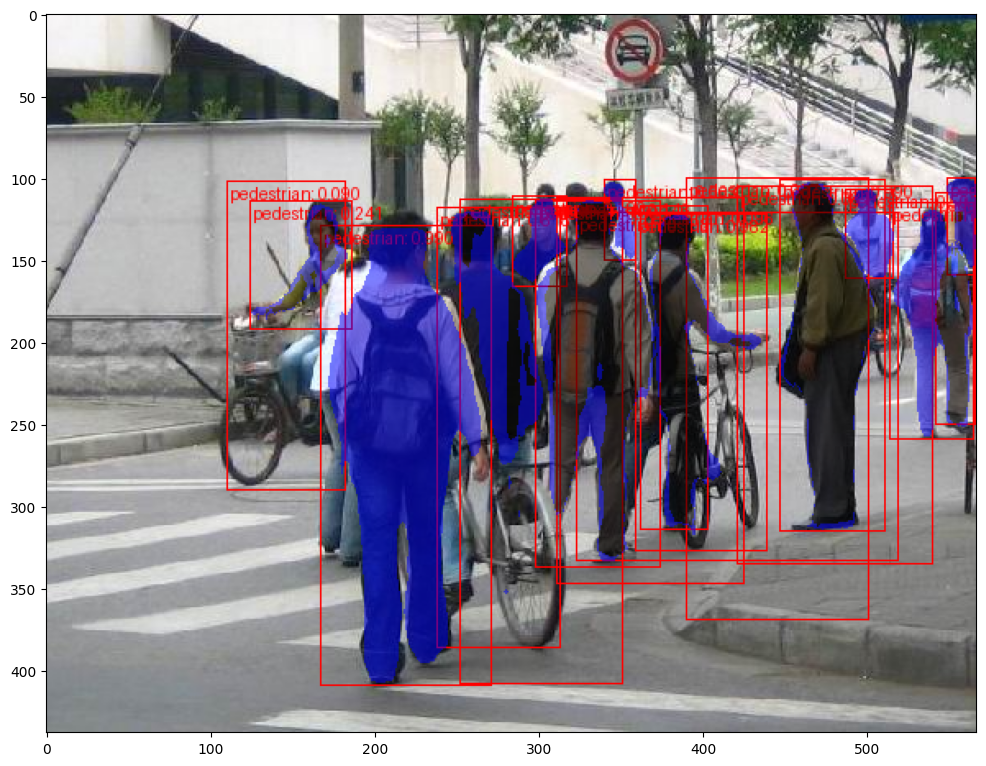

In [84]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))